# **DeltaNet Challenge: implementation, verification, and experiment**

**Goal:** implement DeltaNet recurrence, compute exact coefficients, verify the scalar multiplicative closed-form, run experiments (orthogonal vs colinear keys, β ablation), and provide a small PyTorch module for streaming DeltaNet.

## **Setup**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import os
from functools import partial
np.set_printoptions(precision=4, suppress=True)

# For high precision tests
try:
    import torch
    import torch.nn as nn
except Exception as e:
    print("Torch not available. If you want PyTorch, run: !pip install torch")
    torch = None

## **Global seeds and `dtype` choices**

In [2]:
SEED = 0
np.random.seed(SEED)
USE_FLOAT64 = True   # Avoid precision issues
DTYPE = np.float64 if USE_FLOAT64 else np.float32

# utility for deterministic torch if used
if torch is not None:
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Core numerical functions**

In [3]:
def simulate_delta_S_q(betas, ks, vs, q, dtype=DTYPE):
    """
    Simulate DeltaNet updates and return o_T = S_T @ q.
    - betas: shape (T,)
    - ks: list/array of T vectors each (d,)
    - vs: list/array of T vectors each (d,)
    - q: vector (d,)
    """
    T = len(betas)
    d = ks[0].shape[0]
    S = np.zeros((d, d), dtype=dtype)
    for t in range(T):
        beta = float(betas[t])
        k = ks[t].astype(dtype)
        v = vs[t].astype(dtype)
        # S @ (k k^T) = (S @ k)  k^T  (rank-one)
        Sk = S.dot(k)            # (d,)
        S = S - beta * np.outer(Sk, k) + beta * np.outer(v, k)
    return S.dot(q)

def exact_coeffs(betas, ks, q, dtype=DTYPE):
    """
    Compute exact coefficients alpha_i^{(T)} such that
    o_T = sum_i alpha_i * v_i, using the operator identity.
    Returns alpha: array shape (T,)
    """
    T = len(betas)
    d = ks[0].shape[0]
    # R_list[i] = product_{j=i+1}^{T-1} (I - beta_j k_j k_j^T) q
    R = q.astype(dtype).copy()
    R_list = [None] * T
    # iterate j = T-1 ... 0
    for j in reversed(range(T)):
        R_list[j] = R.copy()
        k = ks[j].astype(dtype)
        R = R - float(betas[j]) * k * (k.dot(R))   # broadcast (d,)
    alphas = np.zeros(T, dtype=dtype)
    for i in range(T):
        alphas[i] = float(betas[i]) * ks[i].astype(dtype).dot(R_list[i])
    return alphas

def output_from_alphas(alphas, vs):
    # vs: list/array T x d
    return sum(float(alphas[i]) * vs[i].astype(DTYPE) for i in range(len(alphas)))

def scalar_coeffs_closedform(betas, a_s, q_scalar, dtype=DTYPE):
    """
    For scalar (1-D) keys a_i and scalar q, compute closed-form
    alpha_i = beta_i * (a_i q) * prod_{j=i+1}^{T-1} (1 - beta_j * a_j^2)
    """
    T = len(betas)
    coeffs = np.zeros(T, dtype=dtype)
    prod = 1.0
    for i in reversed(range(T)):
        s_i = a_s[i] * q_scalar
        coeffs[i] = float(betas[i]) * s_i * prod
        prod *= (1.0 - float(betas[i]) * (a_s[i]**2))
    return coeffs

## **Unit tests**

In [4]:
def test_exactness_random(d=8, T=6):
    betas = 0.3 * np.ones(T)
    ks = [np.random.randn(d).astype(DTYPE) for _ in range(T)]
    vs = [np.random.randn(d).astype(DTYPE) for _ in range(T)]
    q = np.random.randn(d).astype(DTYPE)
    o_sim = simulate_delta_S_q(betas, ks, vs, q)
    alphas = exact_coeffs(betas, ks, q)
    o_pred = output_from_alphas(alphas, vs)
    err = np.linalg.norm(o_sim - o_pred)
    print(f"Exactness test: norm diff = {err:.3e}")
    return err

def test_scalar_closedform():
    T = 6
    betas = 0.2 * np.ones(T)
    a_s = np.random.randn(T)
    vs = np.random.randn(T)
    q = 0.7
    # simulate scalar S
    S = 0.0
    for i in range(T):
        S = S - betas[i] * S * (a_s[i]**2) + betas[i] * vs[i] * a_s[i]
    o_sim = S * q
    coeffs = scalar_coeffs_closedform(betas, a_s, q)
    o_pred = np.sum(coeffs * vs)
    print(f"Scalar closed-form test: abs diff = {abs(o_sim - o_pred):.3e}")
    return abs(o_sim - o_pred)

# Run tests
err1 = test_exactness_random()
err2 = test_scalar_closedform()
assert err1 < 1e-8, "Exactness test failed (too large error). Use float64 and small sizes."
assert err2 < 1e-8, "Scalar closed-form test failed"
print("All tests passed.")

Exactness test: norm diff = 4.661e-15
Scalar closed-form test: abs diff = 2.776e-17
All tests passed.


## **Key generators: orthogonal and colinear**

In [5]:
def generate_colinear_keys(T, d, seed=0):
    """Generate keys colinear with a random direction e."""
    rng = np.random.RandomState(seed)
    e = rng.randn(d)
    e = e / np.linalg.norm(e)
    a = rng.randn(T)  # scalar multipliers
    ks = [float(a[i]) * e for i in range(T)]
    return ks, a, e

def generate_orthogonal_keys(T, d):
    """Generate near-orthogonal keys (use rows of random orthonormal basis if T<=d)."""
    rng = np.random.RandomState(SEED)
    if T <= d:
        # generate orthonormal vectors via QR
        mat = rng.randn(d, d)
        Q, _ = np.linalg.qr(mat)
        ks = [Q[:, i].astype(DTYPE) for i in range(T)]
    else:
        # produce nearly orthogonal by random and Gram-Schmidt
        ks = []
        for i in range(T):
            v = rng.randn(d)
            # orthonormalize w.r.t previous
            for u in ks:
                v = v - (u.dot(v)) * u
            nrm = np.linalg.norm(v)
            if nrm < 1e-8:
                v = rng.randn(d)
                nrm = np.linalg.norm(v)
            ks.append(v / nrm)
    return ks

## **Experiment 1: compare exact alphas to scalar-approx alphas**

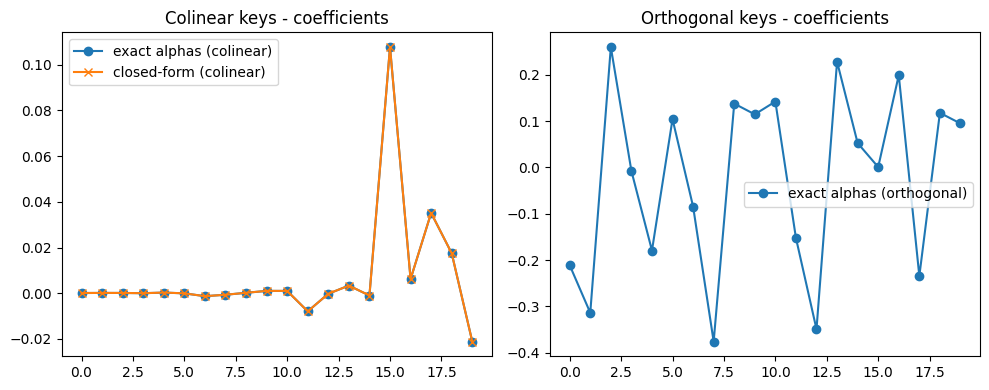

colinear: norm diff o_sim vs o_pred: 7.70188896810111e-16


In [6]:
def run_regime_experiment(T=20, d=32, betaval=0.25):
    betas = betaval * np.ones(T)
    # colinear
    ks_col, a_s, e = generate_colinear_keys(T, d, seed=1)
    vs = [np.random.randn(d).astype(DTYPE) for _ in range(T)]
    q = (np.random.randn(d)).astype(DTYPE)
    # orthogonal
    ks_orth = generate_orthogonal_keys(T, d)
    # exact alphas colinear
    alphas_col = exact_coeffs(betas, ks_col, q)
    o_col_sim = simulate_delta_S_q(betas, ks_col, vs, q)
    o_col_pred = output_from_alphas(alphas_col, vs)
    # for colinear also compute scalar closed form using a_s and q projected onto e
    q_scalar = float(e.dot(q))
    closed_col = scalar_coeffs_closedform(betas, a_s, q_scalar)
    # exact alphas orth
    alphas_orth = exact_coeffs(betas, ks_orth, q)
    # Plots: coefficients
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(alphas_col, marker='o', label='exact alphas (colinear)')
    plt.plot(closed_col, marker='x', label='closed-form (colinear)')
    plt.title("Colinear keys - coefficients")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(alphas_orth, marker='o', label='exact alphas (orthogonal)')
    plt.title("Orthogonal keys - coefficients")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("colinear: norm diff o_sim vs o_pred:", np.linalg.norm(o_col_sim - o_col_pred))

run_regime_experiment(T=20, d=32, betaval=0.25)

## **Experiment 2: coefficient heatmap over time**

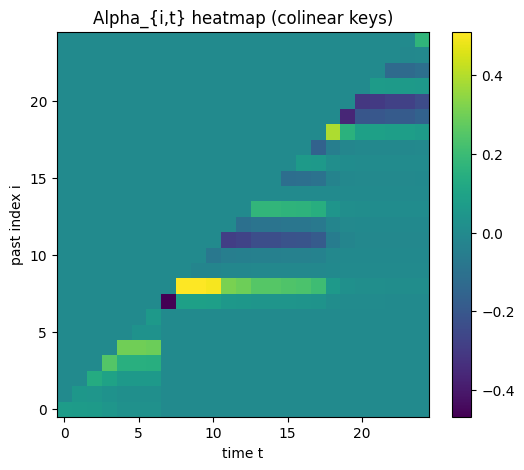

In [7]:
def alpha_matrix_over_time(betas, ks, q):
    T = len(betas)
    # compute alphas for each prefix length t=1..T
    A = np.zeros((T, T))
    for t in range(1, T+1):
        alphas_t = exact_coeffs(betas[:t], ks[:t], q)
        A[:t, t-1] = alphas_t  # rows i, col t-1
    return A

T = 25
d = 24
betas = 0.2 * np.ones(T)
ks, a_s, e = generate_colinear_keys(T, d, seed=2)
vs = [np.random.randn(d).astype(DTYPE) for _ in range(T)]
q = np.random.randn(d).astype(DTYPE)
A = alpha_matrix_over_time(betas, ks, q)
plt.figure(figsize=(6,5))
plt.imshow(A, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel("time t")
plt.ylabel("past index i")
plt.title("Alpha_{i,t} heatmap (colinear keys)")
plt.show()

## **Experiment 3: β ablation and stability**

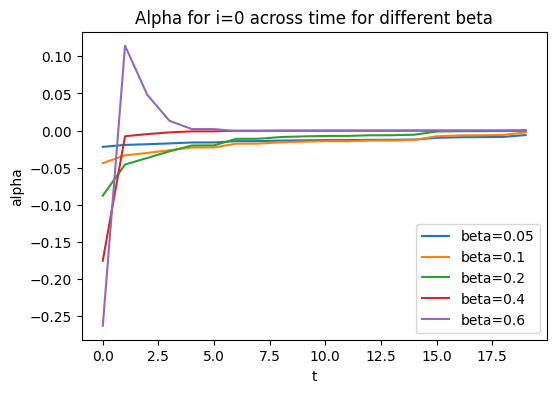

In [8]:
def beta_ablation_plot(T=20, d=16, betas_list=None):
    if betas_list is None:
        betas_list = [0.05, 0.1, 0.2, 0.4, 0.6]
    i = 0  # examine first element's alpha_i over time
    curves = []
    ks, a_s, e = generate_colinear_keys(T, d, seed=3)
    q = np.random.randn(d).astype(DTYPE)
    vs = [np.random.randn(d).astype(DTYPE) for _ in range(T)]
    for b in betas_list:
        betas = b * np.ones(T)
        A = alpha_matrix_over_time(betas, ks, q)
        curves.append(A[i, :])
    plt.figure(figsize=(6,4))
    for bi, curve in zip(betas_list, curves):
        plt.plot(curve, label=f"beta={bi}")
    plt.legend()
    plt.title("Alpha for i=0 across time for different beta")
    plt.xlabel("t")
    plt.ylabel("alpha")
    plt.show()

beta_ablation_plot()

## **PyTorch DeltaNet Module (streaming)**

In [9]:
if torch is not None:
    class DeltaNetLayer(nn.Module):
        def __init__(self, d):
            super().__init__()
            self.d = d
            # no parameters in the plain layer; betas will be provided externally
        def forward_stream(self, keys, values, betas, q_sequence=None, dtype=torch.float64):
            """
            Streaming forward across time dimension.
            keys: (T, d) or (B, T, d)
            values: (T, d) or (B, T, d)
            betas: (T,) or (B, T)
            q_sequence: optional queries for each time (T, d) or (B, T, d)
            Returns outputs: (T, d) or (B, T, d)
            """
            # supports batchless first
            single_batch = (keys.dim() == 2)
            if single_batch:
                T, d = keys.shape
                S = torch.zeros(d, d, dtype=dtype, device=keys.device)
                outputs = []
                for t in range(T):
                    k = keys[t]  # (d,)
                    v = values[t]  # (d,)
                    beta = float(betas[t])
                    Sk = S.matmul(k)  # (d,)
                    S = S - beta * torch.ger(Sk, k) + beta * torch.ger(v, k)
                    q = keys[t] if q_sequence is None else q_sequence[t]
                    outputs.append(S.matmul(q).unsqueeze(0))
                return torch.cat(outputs, dim=0)  # (T, d)
            else:
                raise NotImplementedError("Batch version not implemented in this snippet.")
else:
    print("PyTorch not installed; skip DeltaNet module.")

## **Save results and reproducibility**

In [10]:
outdir = "deltanet_artifacts"
os.makedirs(outdir, exist_ok=True)
np.savez(os.path.join(outdir, "example_run.npz"),
         SEED=SEED, DTYPE=str(DTYPE))
print("Saved artifacts to", outdir)

Saved artifacts to deltanet_artifacts
